In [10]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

csv_path = "fifa_normal_attributes.csv"
df = pd.read_csv(csv_path)


df_filtered = df[['Full Name', 'Pace Total', 'Shooting Total', 'Passing Total', 'Dribbling Total', 'Defending Total', 'Physicality Total', 'Position']].head(5000)  ## top 5000 players in FIFA who are not GK


X = df_filtered.drop(['Position'], axis=1)
y = df_filtered['Position']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

train_data = X_train.to_numpy()
test_data = X_test.to_numpy()
result_arr = np.array([]) 



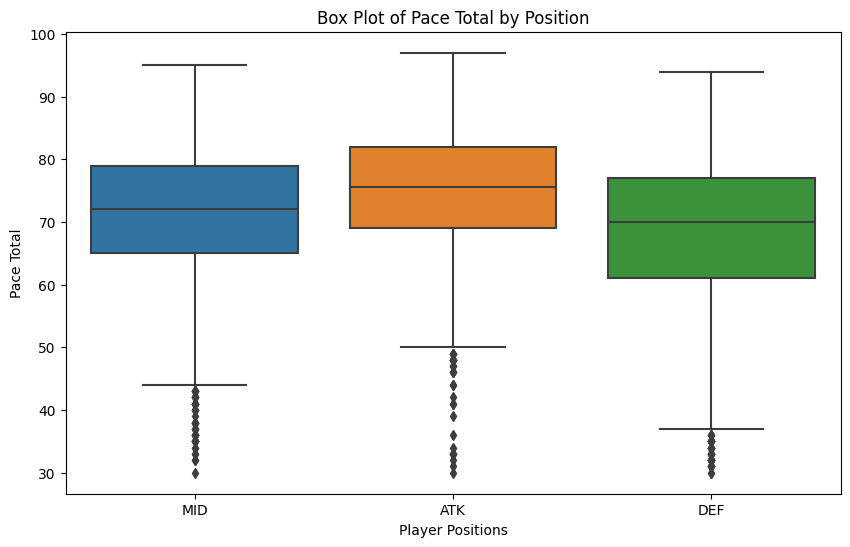

In [79]:
import seaborn as sns
plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Pace Total', order = order)
plt.title('Box Plot of Pace Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Pace Total')
plt.show()

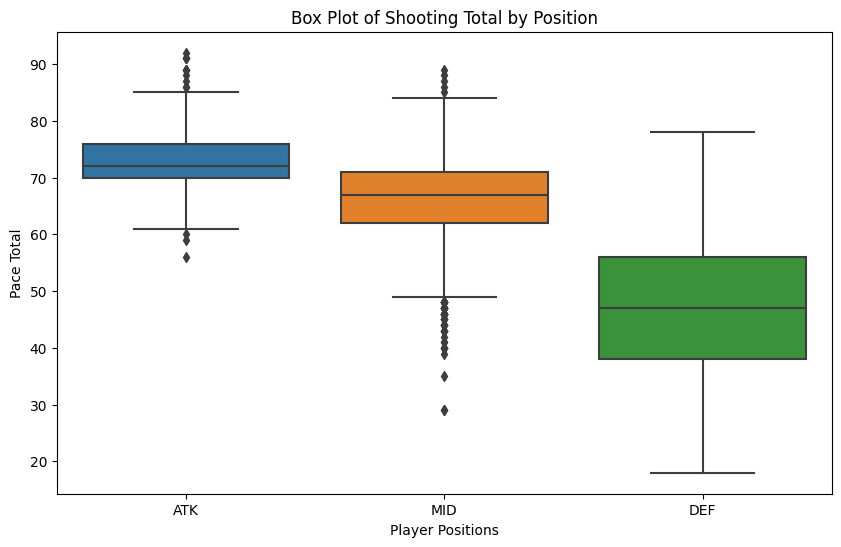

In [81]:
plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Shooting Total', order = order)
plt.title('Box Plot of Shooting Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Shooting Total')
plt.show()

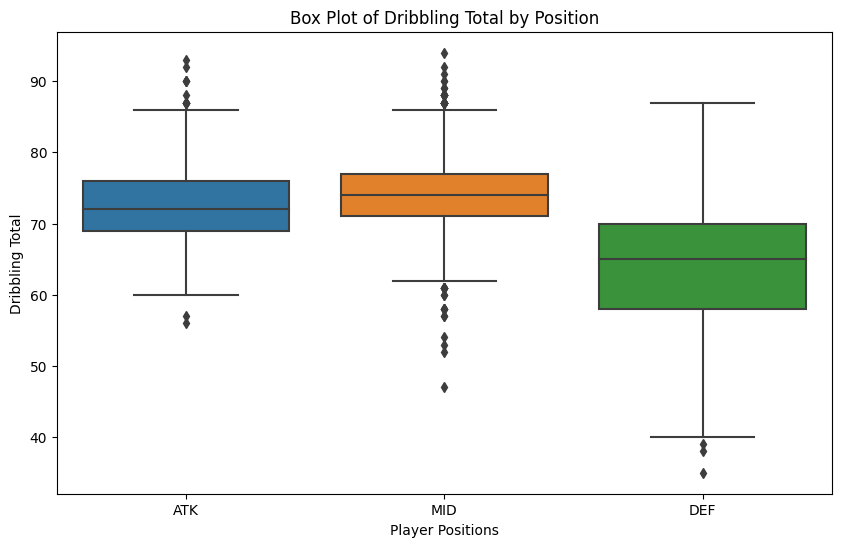

In [82]:

plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Dribbling Total', order = order)
plt.title('Box Plot of Dribbling Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Dribbling Total')
plt.show()

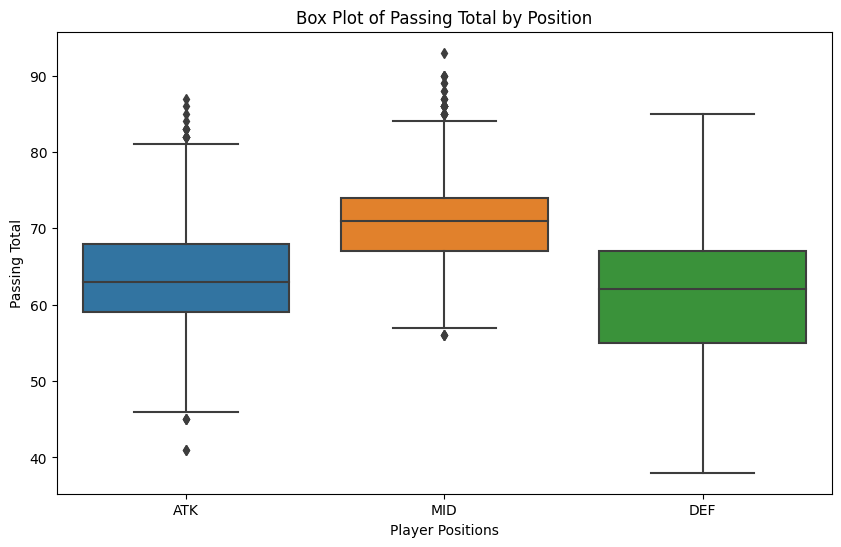

In [83]:

plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Passing Total', order = order)
plt.title('Box Plot of Passing Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Passing Total')
plt.show()

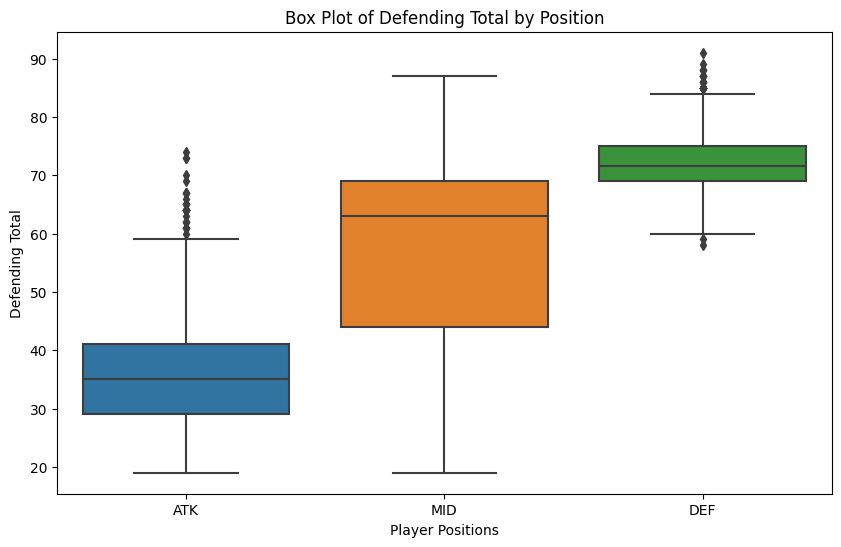

In [84]:

plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Defending Total', order = order)
plt.title('Box Plot of Defending Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Defending Total')
plt.show()

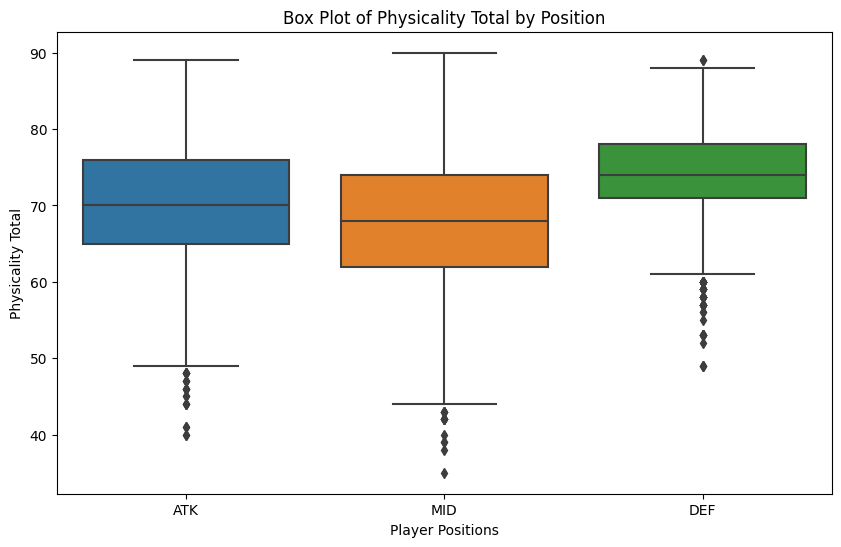

In [85]:

plt.figure(figsize=(10, 6))
order = ['ATK', 'MID', 'DEF']
sns.boxplot(data=df_filtered, x='Position', y='Physicality Total', order = order)
plt.title('Box Plot of Physicality Total by Position')
plt.xlabel('Player Positions')
plt.ylabel('Physicality Total')
plt.show()

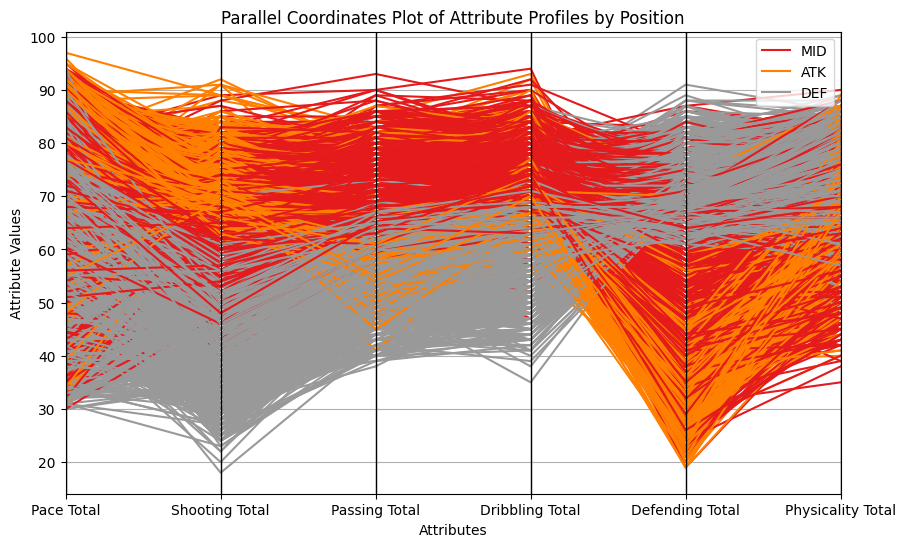

In [86]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(10, 6))
df_parallel = df_filtered.drop('Full Name', axis=1)
df_parallel['Position'] = y
parallel_coordinates(df_parallel, 'Position', colormap='Set1')
plt.title('Parallel Coordinates Plot of Attribute Profiles by Position')
plt.xlabel('Attributes')
plt.ylabel('Attribute Values')
plt.legend(loc='upper right')
plt.show()

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


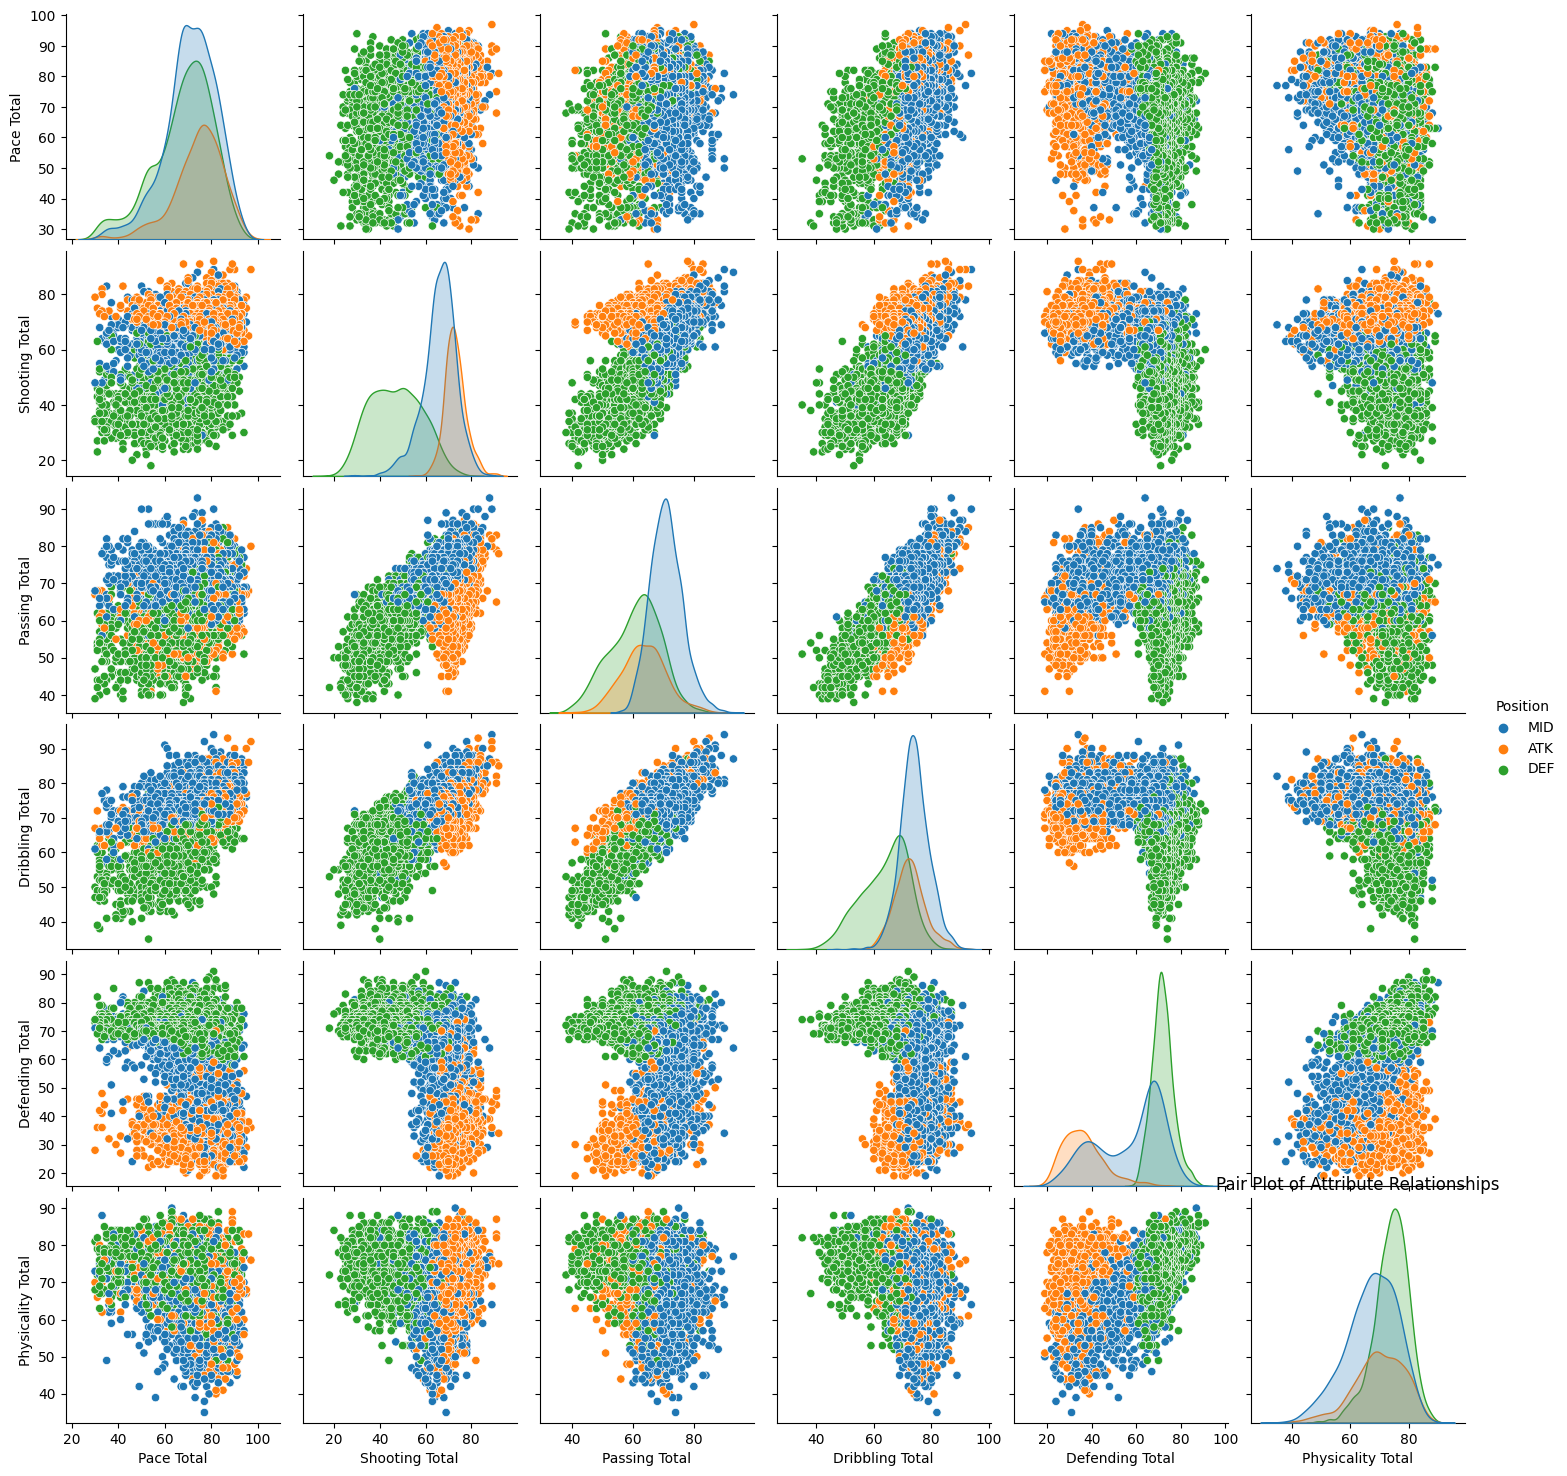

In [87]:
sns.pairplot(df_filtered, hue='Position')
plt.title('Pair Plot of Attribute Relationships')
plt.show()

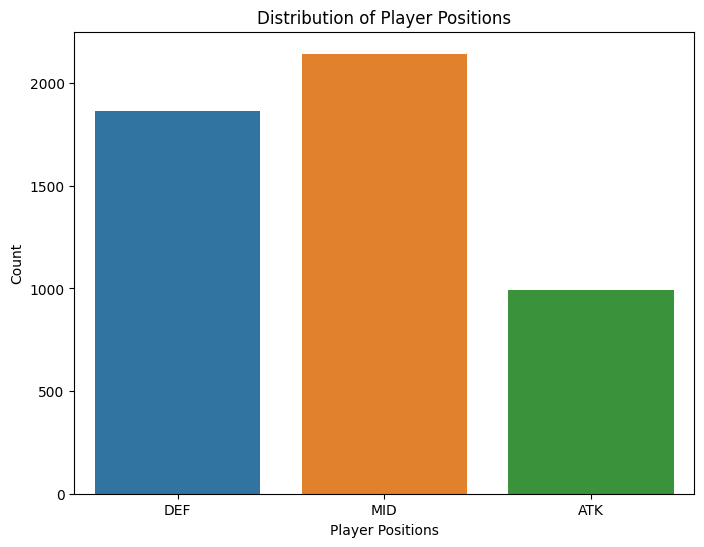

In [89]:
plt.figure(figsize=(8, 6))
position_counts = y.value_counts()
order = ['DEF', 'MID', 'ATK']
sns.barplot(x=position_counts.index, y=position_counts, order=order)
plt.title('Distribution of Player Positions')
plt.xlabel('Player Positions')
plt.ylabel('Count')
plt.show()

In [22]:
#######################################################
########## COMPARISON OF TRAIN AND TEST DATA ##########
#######################################################

def minkowski_distance(X_test, X_train, p):
    dis = {}
    count_test = 0
    result_list = []
    for trainPlayer in X_test.values:
        dis = {}  # Reset the dis dictionary for each trainPlayer
        count_test = 0
        for testPlayer in X_train.values:
            paceDiff = abs(trainPlayer[1] - testPlayer[1])
            shootingDiff = abs(trainPlayer[2] - testPlayer[2])
            passingDiff = abs(trainPlayer[3] - testPlayer[3])
            dribblingDiff = abs(trainPlayer[4] - testPlayer[4])
            defenseDiff = abs(trainPlayer[5] - testPlayer[5])
            physicalityDiff = abs(trainPlayer[6] - testPlayer[6])
            u = paceDiff**p + shootingDiff**p + passingDiff**p + dribblingDiff**p + defenseDiff**p + physicalityDiff**p
            u = u ** (1/p)
            dis[count_test] = u
            count_test += 1

        distance = {k: v for k, v in sorted(dis.items(), key=lambda item: item[1])}
        result_list.append(list(distance))

    result_arr = np.array(result_list)
    return result_arr

In [68]:
def cosine_distance(X_test, X_train):
    dis = {}
    count_test = 0
    result_list = []
    
    # Normalize the vectors
    X_test_new = X_test.drop(['Full Name'], axis=1)
    X_train_new = X_train.drop(['Full Name'], axis=1)
    X_test_norm = np.linalg.norm(X_test_new, axis=1)
    X_train_norm = np.linalg.norm(X_train_new, axis=1)
    
    for trainPlayer in X_test_new.values:
        dis = {}  # Reset the dis dictionary for each trainPlayer
        count_test = 0
        
        for testPlayer in X_train_new.values:
            dot_product = np.dot(trainPlayer, testPlayer)
            cosine_sim = dot_product / (X_test_norm[count_test] * X_train_norm[count_test])
            distance = 1 - cosine_sim
            
            dis[count_test] = distance
            count_test += 1

        distance = {k: v for k, v in sorted(dis.items(), key=lambda item: item[1])}
        result_list.append(list(distance))

    result_arr = np.array(result_list)
    return result_arr


In [55]:
def distance(X_test, X_train, method='minkowski', p=2):
    if method == 'minkowski':
        return minkowski_distance(X_test, X_train, p)
    elif method == 'cosine':
        return cosine_distance(X_test, X_train)

In [47]:
#######################################################
################### KNN APPLICATION ###################
#######################################################

def apply_knn(k, result_arr, y_train, y_test):
    position_train = y_train.to_numpy()
    position_test = y_test.to_numpy()
    count= 0
    truth_count = 0
    decided = np.array([])
    for i, _ in enumerate(result_arr):
        count+=1
        k_list = []
        #print(count, ":",test_data[i])
        for j, _ in enumerate(result_arr[i]):
            if j == k:
                break
            position = position_train[result_arr[i][j]]
            
            k_list.append(position)
        
        attacker = k_list.count("ATK")
        midfielder = k_list.count("MID")
        defender = k_list.count("DEF")
        if attacker > defender and attacker > midfielder:
            #print("Result: ATK")
            decided_position = "ATK"
        elif midfielder > attacker and midfielder > defender:
            #print("Result: MID")
            decided_position = "MID"
        elif defender > attacker and defender > midfielder:
            #print("Result: DEF")
            decided_position = "DEF"
        else:
            #print("Result is unknown (Equal number of instances).")
            decided_position = "-"

        true_position = position_test[i]
        #print("Truth: ", true_position)
        
        #print("---")
        decided = np.append(decided, decided_position)
        
        
        
        if true_position == decided_position:
            truth_count += 1
    
    print("----------------------------------- K value:", k, "-------------------------------------")
    data = [{'Player_Name': pn, 'True_Position': tp, 'Decided_Position': dp} for pn, tp, dp in zip(test_data, y_test, decided)]
    new_df = pd.DataFrame(data)
    #print(new_df)
    truth_rate = (truth_count / count) * 100
    print("------------------------------- Truth Rate: %", truth_rate, "---------------------------------")
    print("\n")
    return truth_rate
    

In [69]:
truth_rates = np.zeros(20)  # Preallocate an array of size 20

for k in range(1, 21):
    result_arr = distance(X_test, X_train, 'minkowski', 1)  # Define the compare() function appropriately
    truth_rate = apply_knn(k, result_arr, y_train, y_test)  # Define the apply_knn() function appropriately
    truth_rates[k-1] = truth_rate  # Assign the truth_rate to the corresponding index in truth_rates



----------------------------------- K value: 1 -------------------------------------
------------------------------- Truth Rate: % 81.5 ---------------------------------


----------------------------------- K value: 2 -------------------------------------
------------------------------- Truth Rate: % 70.1 ---------------------------------


----------------------------------- K value: 3 -------------------------------------
------------------------------- Truth Rate: % 84.8 ---------------------------------


----------------------------------- K value: 4 -------------------------------------
------------------------------- Truth Rate: % 78.7 ---------------------------------


----------------------------------- K value: 5 -------------------------------------
------------------------------- Truth Rate: % 85.3 ---------------------------------


----------------------------------- K value: 6 -------------------------------------
------------------------------- Truth Rate: % 80.2 ----

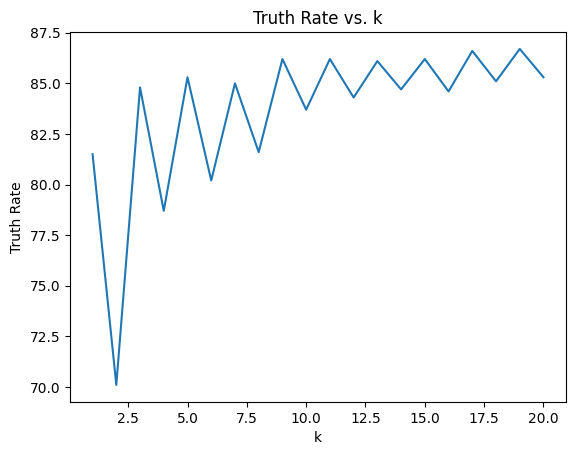

In [108]:
plt.plot(range(1, 21), truth_rates)
plt.xlabel('k')
plt.ylabel('Truth Rate')
plt.title('Truth Rate vs. k')
plt.show()

In [127]:
truth_rates_2 = np.zeros(20)  # Preallocate an array of size 20

for k in range(1, 21):
    result_arr = distance(X_test, X_train, 'minkowski', 2)  # Define the compare() function appropriately
    truth_rate = apply_knn(k, result_arr, y_train, y_test)  # Define the apply_knn() function appropriately
    truth_rates_2[k-1] = truth_rate  # Assign the truth_rate to the corresponding index in truth_rates


----------------------------------- K value: 1 -------------------------------------
------------------------------- Truth Rate: % 80.60000000000001 ---------------------------------


----------------------------------- K value: 2 -------------------------------------
------------------------------- Truth Rate: % 71.2 ---------------------------------


----------------------------------- K value: 3 -------------------------------------
------------------------------- Truth Rate: % 84.8 ---------------------------------


----------------------------------- K value: 4 -------------------------------------
------------------------------- Truth Rate: % 78.4 ---------------------------------


----------------------------------- K value: 5 -------------------------------------
------------------------------- Truth Rate: % 84.6 ---------------------------------


----------------------------------- K value: 6 -------------------------------------
------------------------------- Truth Rate

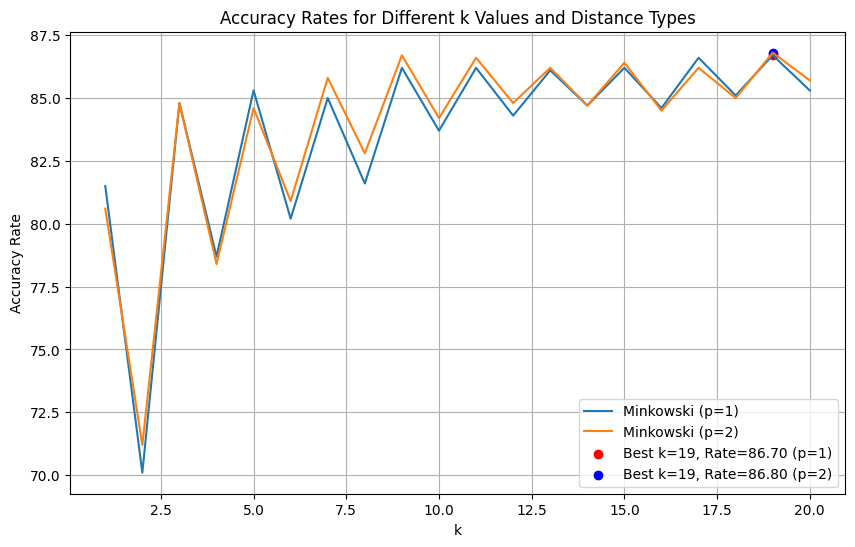

In [129]:

# Find the best k and rate for each distance type
best_k_1 = np.argmax(truth_rates) + 1
best_rate_1 = np.max(truth_rates)
best_k_2 = np.argmax(truth_rates_2) + 1
best_rate_2 = np.max(truth_rates_2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), truth_rates, label='Minkowski (p=1)')
plt.plot(range(1, 21), truth_rates_2, label='Minkowski (p=2)')
plt.scatter(best_k_1, best_rate_1, color='red', label=f'Best k={best_k_1}, Rate={best_rate_1:.2f} (p=1)')
plt.scatter(best_k_2, best_rate_2, color='blue', label=f'Best k={best_k_2}, Rate={best_rate_2:.2f} (p=2)')
plt.title('Accuracy Rates for Different k Values and Distance Types')
plt.xlabel('k')
plt.ylabel('Accuracy Rate')
plt.legend()
plt.grid(True)
plt.show()

In [152]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

X = df_filtered.drop(['Position', 'Full Name'], axis=1)  # Drop 'Position' and 'Full Name' columns
y = df_filtered['Position']

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

best_k = np.argmax(truth_rates) + 1
best_rate = np.max(truth_rates)
knn = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', p=2)
cv_scores = cross_val_score(knn, X, y_encoded, cv=5)

# Print the accuracy scores for each fold
print("Cross-Validation Accuracy Scores:")
print(cv_scores)

# Calculate and print the average accuracy score
avg_cv_score = np.mean(cv_scores)
print("Average Accuracy Score:", avg_cv_score)


Cross-Validation Accuracy Scores:
[0.791 0.843 0.851 0.862 0.834]
Average Accuracy Score: 0.8362


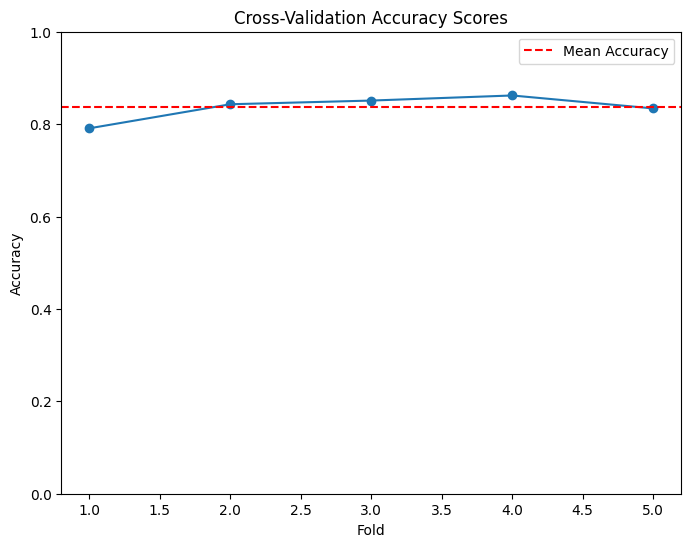

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv_scores, marker='o')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# Calculate and display the mean accuracy score
mean_accuracy = np.mean(cv_scores)
plt.axhline(mean_accuracy, color='r', linestyle='--', label='Mean Accuracy')
plt.legend()

plt.show()


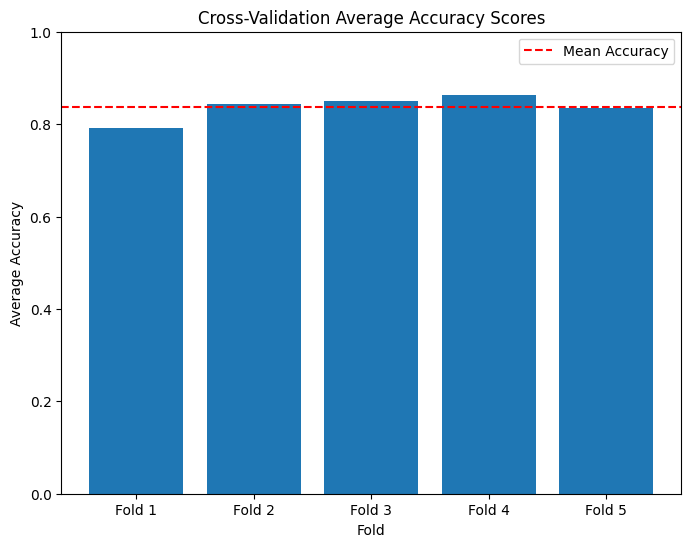

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), cv_scores, tick_label=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
plt.title('Cross-Validation Average Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Average Accuracy')
plt.ylim([0, 1])

# Calculate and display the mean accuracy score
mean_accuracy = np.mean(cv_scores)
plt.axhline(mean_accuracy, color='r', linestyle='--', label='Mean Accuracy')
plt.legend()

plt.show()


In [164]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16478 entries, 0 to 16477
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Full Name          16478 non-null  object
 1   Pace Total         16478 non-null  int64 
 2   Shooting Total     16478 non-null  int64 
 3   Passing Total      16478 non-null  int64 
 4   Dribbling Total    16478 non-null  int64 
 5   Defending Total    16478 non-null  int64 
 6   Physicality Total  16478 non-null  int64 
 7   Position           16478 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.0+ MB
None
